moved to zaratan `02a-*`

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import time
import gc

from scipy.special import gammaln

from multiprocessing import Process, Queue
from functools import wraps

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [5]:
np.round(np.linspace(1, args.num_rois, 5)).astype(int)

array([  1,  44,  86, 129, 172])

In [6]:
args.dc, args.sbm = True, 'o'

args.nested = True if args.sbm in ['h'] else False

args.wait = 120 #6000
args.force_niter = 50
args.num_draws = int((1/2) * args.force_niter)
args.niter = 10

args.total_samples = 225
args.num_iters = args.total_samples // args.force_niter
print(
    f'{[args.force_niter, args.total_samples, args.num_iters]}'
)

args.epsilon = 0.4 # threshold KSD for convergence

# args.Bs = '1' #' '.join([str(i) for i in (np.round(np.linspace(1, args.num_rois, 5)).astype(int))])
args.B = 1
args.gamma = 2.0

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)

[50, 225, 4]


In [7]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f222c0a3df0>

In [8]:
with open(f'graph.pkl', 'wb') as f:
    pickle.dump([g], f)

In [9]:
with open(f'graph.pkl', 'rb') as f:
    [g] = pickle.load(f)

In [10]:
# g = gt.collection.data['polbooks']

In [11]:
state = gt.OverlapBlockState
state_args = dict(deg_corr=False, B=112)
state = gt.minimize_blockmodel_dl(g, state, state_args)

In [13]:
def create_state(args, ):
    state_df = pd.DataFrame(columns=['a', 'd', 'o', 'h', 'm'],)
    state_df.loc['state'] = [
        gt.PPBlockState, gt.BlockState, 
        gt.OverlapBlockState, gt.NestedBlockState,
        gt.ModularityState,
    ]
    state_df.loc['state_args'] = [
        dict(), dict(deg_corr=args.dc, B=args.B), 
        dict(deg_corr=args.dc, B=args.B), dict(deg_corr=args.dc, B=args.B),
        dict(entropy_args=dict(gamma=args.gamma)),
    ]
    state, state_args = state_df[args.sbm]
    return state, state_args

In [16]:
state, state_args = create_state(args, )
if not args.sbm in ['h']:
    state = gt.minimize_blockmodel_dl(g, state, state_args)
else:
    state = gt.minimize_nested_blockmodel_dl(g, state=state, state_args=state_args)
state.entropy()

6416.85947731831

---
testing if multiflip_mcmc_sweep() works for oSBM

In [17]:
b_old = np.array(list(state.b))
dS, nmoves = 0, 0
for i in tqdm(range(10)):
    ret = state.multiflip_mcmc_sweep(beta=np.inf, niter=args.niter)
    dS += ret[0]
    nmoves += ret[1]
b_cur = np.array(list(state.b))

print(dS, nmoves, b_old - b_cur, state.entropy())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

-55.36594125991012 1070103 [0 0 0 ... 0 0 0] 6361.493536058393


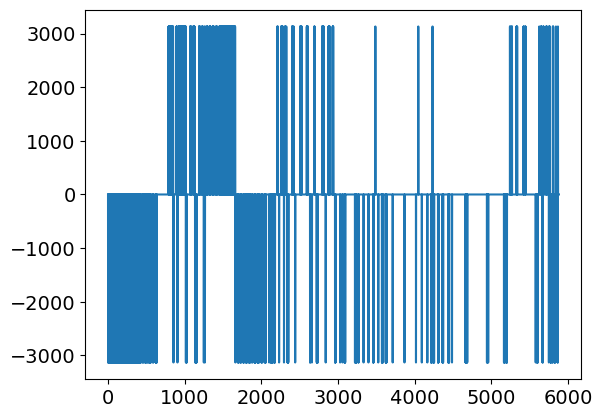

In [39]:
plt.plot(b_old - b_cur)

3.787164934598877


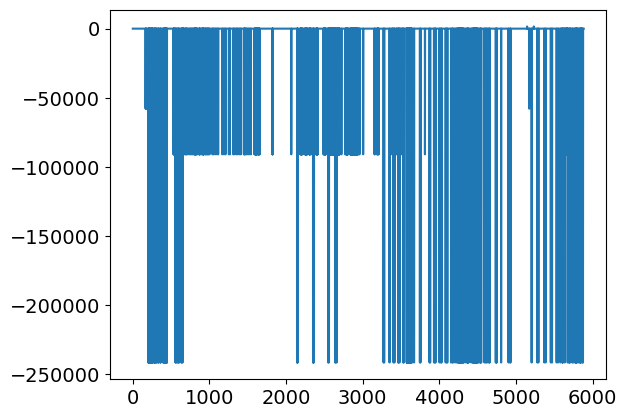

In [22]:
b_old = np.array(list(state.b))
e_old = state.entropy()
gt.mcmc_anneal(state, beta_range=(1, 10), niter=10, mcmc_equilibrate_args=dict(force_niter=10))
b_curr = np.array(list(state.b))
e_curr = state.entropy()

plt.plot(b_old - b_curr)
print(e_curr - e_old)

In [47]:
state.entropy()

6387.86310568706

---
checking if oSBM repeated heurisric worked

In [10]:
files = sorted(glob.glob(f'{ROI_RESULTS_path}/model-fits/sub-SLC07_task-rest/sbm-nd-o/B-1/segment-*_desc-partitions.pkl'))
for file in files:
    with open(file, 'rb') as f:
        [bs, Bs, Bes, dls] = pickle.load(f)
    print(len(dls), np.mean(dls))

300 6242.147165773164
300 6235.351077375528
300 6225.634330002604
300 6234.0777729433
300 6248.734691942875
300 6245.694764608605
300 6245.510100128779
300 6219.044376838035
300 6228.498513261041
300 6227.64230330866


In [11]:
files = sorted(glob.glob(f'{ROI_RESULTS_path}/model-fits/sub-SLC07_task-rest/sbm-nd-o/B-*/desc-evidence.pkl'))
for file in files:
    with open(file, 'rb') as f:
        [L] = pickle.load(f)
        print(L)

-516.2208564493976
-1692.2624019628374
-1616.9882171537256
-1630.5172542428945


In [12]:
files = sorted(glob.glob(f'{ROI_RESULTS_path}/model-fits/sub-SLC01_task-rest/sbm-nd-o/B-*/desc-partition-modes.pkl'))
for file in files:
    with open(file, 'rb') as f:
        [modes] = pickle.load(f)
        print(len(modes))

9
8
8
6
7


---
verifying ModeClusterState() for hSBM

In [9]:
files = sorted(glob.glob(f'{ROI_RESULTS_path}/model-fits/sub-SLC01_task-rest/sbm-nd-h/B-1/desc-partitions.pkl'))
files
for file in files:
    with open(file, 'rb') as f:
        [bs, Bs, Bes, dls] = pickle.load(f)
len(bs)

99999

In [11]:
files = sorted(glob.glob(f'{ROI_RESULTS_path}/model-fits/sub-SLC01_task-rest/sbm-nd-h/B-1/desc-pmode.pkl'))
files
for file in files:
    with open(file, 'rb') as f:
        [pmode] = pickle.load(f)
pmode

In [12]:
gt.__version__

'2.96 (commit c1126da2, )'

In [17]:
H = pmode.posterior_entropy()
H

50.15935137730287

In [20]:
logB = np.mean([sum(gammaln(len(np.unique(bl))+1) for bl in b) for b in bs])
logB

28.96644105287572

In [14]:
pmode.get_modes()

---
verifying cluster-bs.py script for oSBM

In [8]:
def load_data(args, SBM_path):
    segment_files = sorted(glob.glob(f'{SBM_path}/segment-*_desc-partitions.pkl'))
    bs, Bs, Bes, dls = [], [], [], []
    for seg_file in tqdm(segment_files[:1]):
        with open(f'{seg_file}', 'rb') as f:
            [bs_, Bs_, Bes_, dls_] = pickle.load(f)
        bs += [bs_]
        Bs += [Bs_]
        Bes += [Bes_]
        dls += [dls_]
    
    bs = sum(bs, [])
    Bs = np.sum(Bs, axis=0)
    Bes = sum(Bes, [])
    dls = sum(dls, [])

    return bs, Bs, Bes, dls

In [9]:
def posterior_modes(args, bs):
    cmode = gt.ModeClusterState(bs, nested=args.nested, relabel=False)
    gt.mcmc_equilibrate(cmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    cmode.relabel(maxiter=1000)
    return cmode

In [10]:
SBM_path = f'{ROI_RESULTS_path}/model-fits/sub-SLC01_task-rest/sbm-nd-o/B-1'
bs, Bs, Bes, dls = load_data(args, SBM_path)
len(bs)

100%|██████████| 1/1 [00:00<00:00, 58.76it/s]


300

In [11]:
pmode = gt.PartitionModeState(bs, relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

-16640.785912881962
-2740.0450123250603
-1094.1874494390004
-966.3358742835399
-334.20915945302113
-312.1350760860232
-70.71882184604056
-21.462862462041812
-9.340510587207973e-10
-9.340510587207973e-10


In [12]:
bs = pmode.get_partitions()
bs = [v for k, v in sorted(bs.items())]

In [13]:
cmode = posterior_modes(args, bs)

In [14]:
modes = cmode.get_modes()
modes

In [15]:
from scipy.special import gammaln
H = cmode.posterior_entropy()
H
logB = np.mean(gammaln(np.array([len(np.unique(b)) for b in bs]) + 1))
-np.mean(dls), logB, H

# -np.mean(dls) + logB + H

(-6338.710549063952, 37.65742500664611, 4349.139492473658)

In [16]:
bs

[array([32,  1,  2, ..., 16, 16, 16]),
 array([ 8,  7,  3, ..., 16, 16, 16]),
 array([32,  1,  3, ..., 16, 12, 16]),
 array([ 8,  5,  3, ..., 12, 12, 12]),
 array([ 8, 14,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([32,  1,  2, ..., 16, 16, 16]),
 array([ 8, 14,  3, ..., 16, 16, 16]),
 array([ 8,  2,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 6,  1,  3, ..., 16, 12, 16]),
 array([ 8,  1,  3, ..., 12, 12, 12]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ...,  9, 16,  9]),
 array([ 7,  3,  3, ..., 16, 16, 16]),
 array([32, 23,  3, ..., 16, 16, 16]),
 array([ 8, 14,  3, ...,  0, 16,  0]),
 array([ 8,  3,  3, ..., 12, 16, 12]),
 array([ 7, 14,  3, ..., 16, 16, 16]),
 array([ 8, 14,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 16, 16, 16]),
 array([ 7, 14,  3, ..., 16, 16, 16]),
 array([ 8,  1,  3, ..., 

---
part 1: mcmc initial point

In [42]:
def mcmc_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of blocks
    Bes = [] # number of effective blocks
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        # B = s.get_nonempty_B()
        # Bs[B] += 1
        Bes.append(s.get_Be())
        dls.append(s.entropy())

    gt.mcmc_equilibrate(
        state,
        wait=args.wait,
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

In [43]:
def check_diversity(Bes, length):
    """
    Returns True if the Be sequence is diverse (not stuck),
    based on both convergence flatness and histogram entropy.
    Requires both: NOT converged AND entropy above threshold.
    """
    if len(Bes) < length:
        return False

    recent = np.array(Bes[-length:])

    # --- Convergence check ---
    diffs = np.abs(np.diff(recent))
    max_delta = np.max(diffs)
    var = np.var(recent)
    cv = np.std(recent) / (np.mean(recent) + 1e-6)
    not_converged = not (
        max_delta < 2 and
        var < 1e-2 and
        cv < 0.01
    )

    # --- Entropy check ---
    values, counts = np.unique(recent, return_counts=True)
    probs = counts / counts.sum()
    entropy = -np.sum(probs * np.log(probs + 1e-12))
    max_entropy = np.log(len(probs))
    norm_entropy = entropy / max_entropy if max_entropy > 0 else 0.0
    entropy_diverse = norm_entropy > 0.5

    # --- Final decision: BOTH must be true ---
    is_diverse = not_converged and entropy_diverse

    print(f"   diversity check:")
    print(f"     maxΔ = {max_delta:.3f}, var = {var:.4f}, cv = {cv:.4f} → not_converged: {not_converged}")
    print(f"     norm_entropy = {norm_entropy:.3f} → entropy_diverse: {entropy_diverse}")
    print(f"     → overall: {'diverse' if is_diverse else 'stuck'}")

    return is_diverse

In [44]:
def get_initial_state(args, g, diverse=False):
    
    args.wait = 120 #6000
    args.force_niter = 50
    args.num_draws = int((1/2) * args.force_niter)
    args.niter = 10

    attempt = 0
    while not diverse:
        state, state_args = create_state(args)
        state = gt.minimize_blockmodel_dl(g, state=state, state_args=state_args)
        state, bs, Bs, Bes, dls = mcmc_eq(args, g, state)
        diverse = check_diversity(Bes, 20)
        print(f'attempt {attempt} unsuccessful')
        attempt += 1

    print(f'attempt {attempt} successful')
    return state, Bes

In [14]:
# state, Bes = get_initial_state(args, g, False) 

state, state_args = create_state(args)
state = gt.minimize_blockmodel_dl(g, state=state, state_args=state_args)
state, bs, Bs, Bes, dls = mcmc_eq(args, g, state)
diverse = check_diversity(Bes, 20)

   diversity check:
     maxΔ = 0.000, var = 0.0000, cv = 0.0000 → not_converged: False
     norm_entropy = 0.000 → entropy_diverse: False
     → overall: stuck


In [17]:
existing = Bes.copy()

In [15]:
new_data = Bes.copy()

In [19]:
combined = existing + new_data
len(combined)

98

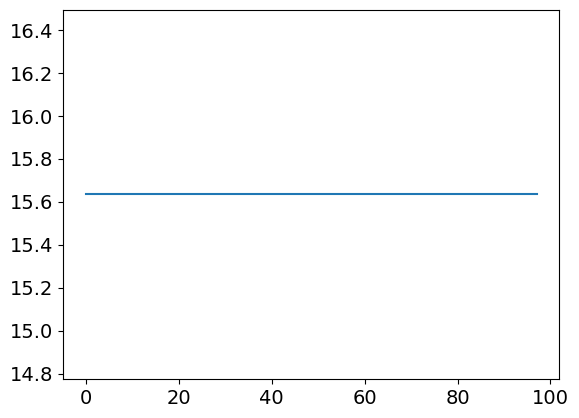

In [ ]:
plt.plot(Bes)

In [15]:
args.force_niter = 200
state, bs, Bs, Bes, dls = mcmc_eq(args, g, state)

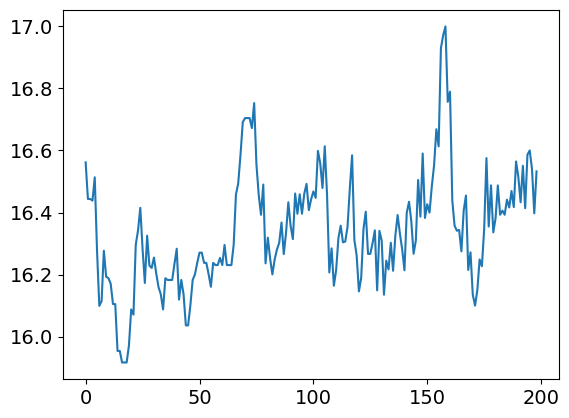

In [16]:
plt.plot(Bes)

---
DO NOT USE THIS PART, SOMEHOW NOT WORKING!!! SIMPLY RUN MCMC, DON'T CARE ABOUT REQUIRED MEMORY FOR NOW.
part 2: mitigating excessive memory usage

In [17]:
def with_timeout(seconds=5):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            def worker(queue):
                result = func(*args, **kwargs)
                queue.put(result)

            queue = Queue()
            process = Process(target=worker, args=(queue,))
            process.start()
            process.join(seconds)

            if process.is_alive():
                process.terminate()
                return None
            
            return queue.get()
        return wrapper
    return decorator

@with_timeout(90)
def mcmc_segment_eq(args, g, state):
    bs = [] # partitions
    Bs = np.zeros(g.num_vertices() + 1) # number of blocks
    Bes = [] # number of effective blocks
    dls = [] # description length history
    def collect_partitions(s):
        bs.append(s.b.a.copy())
        # B = s.get_nonempty_B()
        # Bs[B] += 1
        Bes.append(s.get_Be())
        dls.append(s.entropy())

    gt.mcmc_equilibrate(
        state,
        wait=args.wait,
        force_niter=args.force_niter,
        mcmc_args=dict(niter=args.niter),
        callback=collect_partitions,
    )
    return state, bs, Bs, Bes, dls

def run_mcmc_segment_eq(args, g, state):
    bs, Bs, Bes, dls = [], [], [], []

    for idx_segments in tqdm(range(args.num_segments)):
        res = mcmc_segment_eq(args, g, state)
        if res is not None:
            state, bs_, Bs_, Bes_, dls_ = res
            bs.extend(bs_)
            Bs.extend(Bs_)
            Bes.extend(Bes_)
            dls.extend(dls_)

            # force garbage collection
            del bs_, Bs_, Bes_, dls_
            gc.collect()
    
    return state, bs, Bs, Bes, dls

def run_mcmc_in_segments(args, g, state):
    bs, Bs, Bes, dls = [], [], [], []

    for idx_segments in tqdm(range(args.num_segments)):
        
        state, bs_, Bs_, Bes_, dls_ = mcmc_eq(args, g, state)

        bs.extend(bs_)
        Bs.extend(Bs_)
        Bes.extend(Bes_)
        dls.extend(dls_)

        # force garbage collection
        del bs_, Bs_, Bes_, dls_
        gc.collect()
    
    return state, bs, Bs, Bes, dls

In [18]:
args.force_niter = 5
args.total_samples = 10
args.num_segments = args.total_samples // args.force_niter
print(
    f'{[args.force_niter, args.total_samples, args.num_segments]}'
)

[5, 10, 2]


In [ ]:
# state, bs, Bs, Bes, dls = run_mcmc_segment_eq(args, g, state)

from tqdm import tqdm
bs, Bs, Bes, dls = [], [], [], []
with tqdm(total=args.num_segments) as pbar:
    while len(Bes) < args.total_samples:
        res = mcmc_segment_eq(args, g, state)
        if res is not None:
            state, bs_, Bs_, Bes_, dls_ = res
            bs.extend(bs_)
            Bs.extend(Bs_)
            Bes.extend(Bes_)
            dls.extend(dls_)
            pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [23:00<?, ?it/s]


KeyboardInterrupt: 

Process Process-16:
Traceback (most recent call last):
  File "/home/govindas/miniconda3/envs/gt/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/govindas/miniconda3/envs/gt/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1401458/1216830863.py", line 6, in worker
    result = func(*args, **kwargs)
  File "/tmp/ipykernel_1401458/1216830863.py", line 35, in mcmc_segment_eq
    gt.mcmc_equilibrate(
  File "/home/govindas/miniconda3/envs/gt/lib/python3.9/site-packages/graph_tool/inference/mcmc.py", line 125, in mcmc_equilibrate
    delta, nattempts, nmoves = state.multiflip_mcmc_sweep(**mcmc_args)
  File "/home/govindas/miniconda3/envs/gt/lib/python3.9/site-packages/graph_tool/inference/base_states.py", line 79, in wrapper
    ret = func(self, *args, **kwargs)
  File "/home/govindas/miniconda3/envs/gt/lib/python3.9/site-packages/graph_tool/inference/base_states.py

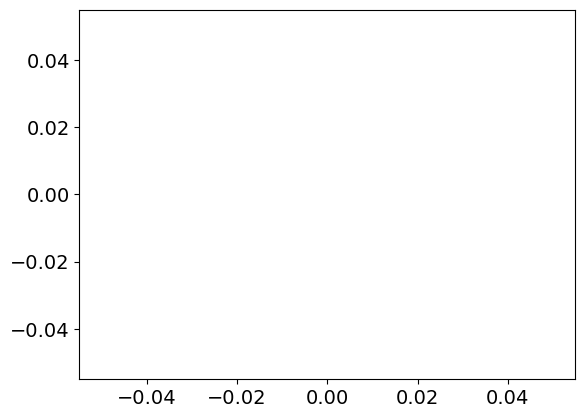

In [20]:
plt.plot(Bes)